In [2]:
import os
import torch
import wandb
import rasterio
import logging

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
import pandas as pd

from glob import glob
from codecarbon import EmissionsTracker
from tqdm.notebook import tqdm
from argparse import ArgumentParser
from represent.datamodules.uc4_cloud_detection import UC4CloudDetectionDataModule, UC4CloudDetectionDataset
from represent.models.uc4_odc import DeepClusterV2
from represent.callbacks.delayed_unfreeze import DelayedUnfreeze
from represent.models.moco import DualMoco
from represent.transforms.augmentations import get_data_augmentation
from represent.tools.utils import seed_all
from represent.tools.plots import plot_img_grid

from pl_bolts.models.regression import LogisticRegression
from pytorch_lightning.loggers import WandbLogger
from datetime import datetime

from tqdm.notebook import tqdm

torch.backends.cudnn.benchmark = True
logger = logging.getLogger()
logger.setLevel(logging.WARNING)


/home/lloyd/anaconda3/envs/epfl2/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [93]:
config_dc = dict(
    # DataModule Settings
    data_dir = "/data/lloyd/RepreSent/UC4/WHUS2-CD+/prepared/output/",
    seed = 42,
    batch_size = 128,
    num_workers = 8,
    training_set_fraction = 0.70,
    patch_size = 128,
    clustering = True,
    
    # Trainer Settings
    gpus = 1,
    accelerator="gpu",
    strategy = None,
    
    # Model Parameters
    use_mlp = False,
    input_ch = 13,
    num_classes = 21,
    backbone = "resnet18",
    proj_hidden_dim = 2048,
    proj_output_dim = 128,
    temperature = 0.1,
    kmeans_iters = 10,
#     checkpoint = "represent/represent/weights/moco_resnet18.pth",
    
    # Optimizer Parameteres
    optimizer = "Adam",
    scheduler = "CosineAnnealingLR",
    momentum = 0.9,
    max_epochs = 100,
    learning_rate = 0.6,
    classifier_lr = 0.1,
)

parser = ArgumentParser()
parser = pl.Trainer.add_argparse_args(parser)
parser = DeepClusterV2.add_model_specific_args(parser)
parser = UC4CloudDetectionDataModule.add_model_specific_args(parser)

args_dc, arg_strings = parser.parse_known_args([], None)
for key, value in config_dc.items():
    setattr(args_dc, key, value)

seed_all(config['seed'])

Global seed set to 42


In [3]:
wandb.finish()
ts = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
run_name = f"UC4_DC_{ts}"
logger = WandbLogger(project="RepreSent_UC4", name=run_name, log_model=True, save_code=True)
# logger = None

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hughes-lloyd. Use `wandb login --relogin` to force relogin


In [3]:
uc4_datamodule = UC4CloudDetectionDataModule.from_argparse_args(args_dc,)

In [4]:
# args.classification_head = torch.nn.Linear(512, config['num_classes'])
# args.classification_head = torch.nn.Sequential(
#     torch.nn.Conv2d(512, 64, kernel_size=3, padding=1),
#     torch.nn.InstanceNorm2d(64),
#     torch.nn.ReLU(),
#     torch.nn.Conv2d(64, config['num_classes'], kernel_size=1)
# )

model = DeepClusterV2(**args_dc.__dict__)

# Pretrain the Deep Cluster Network

In [6]:
checkpointer = pl.callbacks.ModelCheckpoint(
    dirpath=f'checkpoints/UC4_DC/{run_name}',
    filename="{epoch}-{val_acc1:.3f}",
    monitor="val_acc1",
    mode="max",
    save_last=True,
)

early_stopping_callback = pl.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=15)

callbacks = [checkpointer,]

In [7]:
trainer = pl.Trainer.from_argparse_args(args, enable_checkpointing=True, 
                                        logger=logger, callbacks=callbacks, 
                                        auto_lr_find=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
try:
    run = trainer.fit(model, datamodule=uc4_datamodule)
finally:
    wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name       | Type       | Params
------------------------------------------
0 | backbone   | ResNet     | 11.2 M
1 | classifier | Linear     | 5.6 K 
2 | projector  | Sequential | 1.3 M 
3 | prototypes | ModuleList | 1.2 M 
------------------------------------------
12.5 M    Trainable params
1.2 M     Non-trainable params
13.7 M    Total params
54.730    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/lloyd/anaconda3/envs/epfl2/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
train_acc1_epoch,▁▁▂▃▅▇▇█████████████████
train_acc1_step,▁▁▂▁▂▃▄▅▅▆█▆▇▇▇█▇▇▆▇▇▇█▇▇▆▇▇▇▇▇▇▇▇▇▇▆▇██
train_acc5_epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▆▆▇▇███
train_acc5_step,▃▁▄▄▅▁▄▇▅▁▇▃▅▄▆▇▄▄▁▅▆▅█▆▅▃▆▆▅▅▆▆▆▆▆▇▄▆█▇
train_class_loss_epoch,███▇▇▇▆▆▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁
train_class_loss_step,██▇█▇█▇▇▇▇▆▆▆▅▅▄▅▄▅▄▃▃▂▃▄▄▃▂▃▃▃▂▂▂▂▂▃▂▁▁
train_deepcluster_loss_epoch,█▇▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
train_deepcluster_loss_step,██▆▅▆▄▅▄▄▄▄▄▄▃▃▃▃▂▃▂▃▂▂▃▂▂▂▂▂▂▂▂▁▁▂▁▃▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_acc1,▁▁▃▄▆▇██████████████████


# Let's look at the clusters

In [95]:
from glob import glob
import os

run = wandb.init()
artifact = run.use_artifact('hughes-lloyd/RepreSent_UC4/model-29b0ogwc:v0', type='model')
artifact_dir = artifact.download()
checkpoint = os.path.join(artifact_dir, "model.ckpt")

model_dc = DeepClusterV2(**args_dc.__dict__)
model_dc.load_state_dict(torch.load(checkpoint)['state_dict'], strict=False)

model_dc = model_dc.to('cuda')
model_dc = model_dc.eval()

wandb: Downloading large artifact model-29b0ogwc:v0, 64.92MB. 1 files... Done. 0:0:0.0


In [105]:
datamodule = UC4CloudDetectionDataModule.from_argparse_args(args_dc,)
datamodule.setup("test")
dset_test = datamodule.test_dataset

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'model' is the trained deep clustering model and 'test_dataset' is the test dataset
# Extract features from the test dataset
# features = model.encode(test_dataset)  # Replace 'encode' with the appropriate method from your model

features = []
clusters = []
image_id = []
with torch.no_grad():
    for i in tqdm(range(len(dset_test))):
        im, lb = dset_test[i]
        image_id.append(i)
        out = model_dc(im[np.newaxis,].to('cuda'))
        features.append(out['z'].to('cpu').numpy()[0,])
        clusters.append(torch.argmax(out['logits']).to('cpu').numpy())

features = np.array(features)
clusters = np.array(clusters)

  0%|          | 0/9134 [00:00<?, ?it/s]

/home/lloyd/anaconda3/envs/epfl2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lloyd/anaconda3/envs/epfl2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


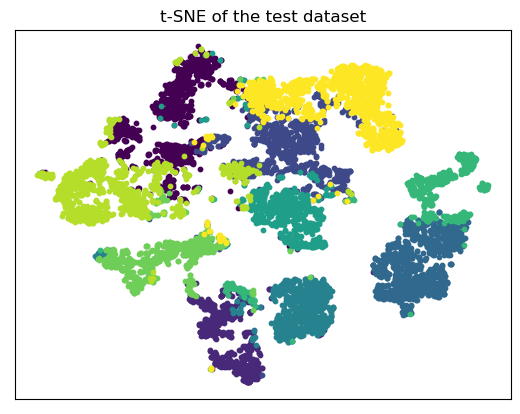

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# # Assuming 'data' is the list of 128-D vectors
data_array = np.array(features)

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(data_array)

# Cluster the data using k-means
n_clusters = 10  # Set the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_assignments = kmeans.fit_predict(data_array)

# Create a scatter plot of the clusters
cmap = plt.cm.get_cmap('viridis', n_clusters)
fig, ax = plt.subplots()

cluster_indices = []  # To store the indices of points in each cluster

for cluster_idx in range(n_clusters):
    points = reduced_data[cluster_assignments == cluster_idx]
    indices = np.where(cluster_assignments == cluster_idx)[0]  # Get the indices of points in the current cluster
    cluster_indices.append(indices)  # Append the indices to the list
    ax.scatter(points[:, 0], points[:, 1], s=10, c=[cmap(cluster_idx)], label=f"Cluster {cluster_idx+1}")

# ax.legend()
ax.set_title("t-SNE of the test dataset")
plt.xticks([])
plt.yticks([])

plt.show()
# Print the indices of points in each cluster
# for i, indices in enumerate(cluster_indices):
#     print(f"Indices of points in Cluster {i+1}: {indices}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


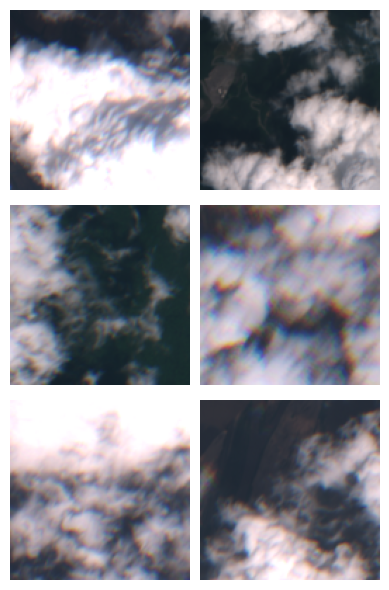

In [236]:
c = 1

ims = []
for j in np.random.choice(cluster_indices[c], 6):
    im, lb = dset_test[j]
    ims.append(im.numpy().transpose(1,2,0)[:,:,(3,2,1)])

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(4, 6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(ims[i]*1.5)  # Use the appropriate colormap for your images (e.g., 'gray', 'viridis', etc.)
    ax.axis('off')
#     ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()   


# Finetune the model

In [3]:
import wandb

run = wandb.init()
artifact = run.use_artifact('hughes-lloyd/RepreSent_UC4/model-29b0ogwc:v0', type='model')
artifact_dir = artifact.download()
checkpoint = os.path.join(artifact_dir, "model.ckpt")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hughes-lloyd. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact model-29b0ogwc:v0, 64.92MB. 1 files... Done. 0:0:0.0


In [16]:
checkpoint = './artifacts/model-29b0ogwc:v0/model.ckpt'

In [17]:
from represent.models.uc4_resnet import UC4ResNet

config = dict(
    # DataModule Settings
    data_dir = "/data/lloyd/RepreSent/UC4/WHUS2-CD+/prepared/output/",
    seed = 42,
    batch_size = 8,
    num_workers = 16,
    training_set_fraction = 0.80,
    limit_dataset = 0.25,
    patch_size = 128,
    
    # Trainer Settings
    gpus = 1,
    accelerator="gpu",
    strategy = None,
    
    # Model Parameters
    use_mlp = False,
    num_classes = 1,
    input_ch = 13,
    backbone = "resnet18",
    segmentation = True,
#     checkpoint = "represent/represent/weights/moco_resnet18.pth",
    checkpoint=checkpoint,
    
    # Optimizer Parameteres
    optimizer = "Adam",
    scheduler = "CosineAnnealingLR",
    momentum = 0.9,
    max_epochs = 50,
    learning_rate = 0.04,
)

parser = ArgumentParser()
parser = pl.Trainer.add_argparse_args(parser)
parser = UC4ResNet.add_model_specific_args(parser)
parser = UC4CloudDetectionDataModule.add_model_specific_args(parser)

args, arg_strings = parser.parse_known_args([], None)
for key, value in config.items():
    setattr(args, key, value)

seed_all(config['seed'])

Global seed set to 42


In [4]:
wandb.finish()
ts = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
run_name = f"UC4_DC_ResNet_{ts}"
logger = WandbLogger(project="RepreSent_UC4", name=run_name, log_model=True, save_code=True)
# logger = None

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hughes-lloyd. Use `wandb login --relogin` to force relogin


In [5]:
uc4_datamodule = UC4CloudDetectionDataModule.from_argparse_args(args,)

In [6]:
18306*0.8*0.15

2196.7200000000003

In [18]:
# args.classification_head = torch.nn.Linear(512, config['num_classes'])
args.classification_head = torch.nn.Sequential(
    torch.nn.Conv2d(512, config['num_classes'], kernel_size=1),
)

model = UC4ResNet(**args.__dict__)

## Load the Deep Cluster Backbone

In [7]:
if 'checkpoint' in config:
    model.load_from_checkpoint(config['checkpoint'], filter_and_remap="backbone")

In [8]:
checkpointer = pl.callbacks.ModelCheckpoint(
    dirpath=f'checkpoints/UC4_DeepCluster_FT/{run_name}',
    filename="{epoch}-{val_acc:.2f}",
    monitor="val_acc",
    mode="max",
    save_last=True,
)

early_stopping_callback = pl.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=15)

unfreezer = DelayedUnfreeze(backbone_id="model", unfreeze_at_epoch=5, train_frozen_bn=True, reset_lr=5e-3)

callbacks = [checkpointer, early_stopping_callback, unfreezer]

# for p in model.model.parameters():
#     p.requires_grad = False

In [9]:
trainer = pl.Trainer.from_argparse_args(args, enable_checkpointing=True, 
                                        logger=logger, callbacks=callbacks, 
                                        auto_lr_find=False)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
try:
    run = trainer.fit(model, datamodule=uc4_datamodule)
finally:
    wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type               | Params
--------------------------------------------------------
0 | model            | ResNet             | 11.2 M
1 | classifier       | Sequential         | 513   
2 | iou_metric_train | BinaryJaccardIndex | 0     
3 | iou_metric_val   | BinaryJaccardIndex | 0     
4 | oa_train         | BinaryAccuracy     | 0     
5 | oa_val           | BinaryAccuracy     | 0     
--------------------------------------------------------
10.1 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.834    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/lloyd/anaconda3/envs/epfl2/lib/python3.8/site-packages/pytorch_lightning/callbacks/finetuning.py:210: UserWarning: The provided params to be frozen already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▄▅▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
train_iou,▁▃▄▅▄▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
train_loss,▇▄▃▃█▅▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▄▆▆▅▅▅▅▅▅▅▅▅▆▆▆▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
val_iou,▁▄▆▆▆▅▅▅▅▅▅▅▅▆▆▆▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
val_loss,▅▃▃▄▇█▅▄▇▃▄▃▇▃▃▃▃▄▁▄▃▄▂▃▂▂▃▁▂▃▂▂▁▁▂▂▂▂▅▁
epoch,49
train_acc,0.97454
train_iou,0.85403


# Find Learning Rate

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.04365158322401656
Restoring states from the checkpoint path at /home/lloyd/Documents/Experiments/RepreSent/.lr_find_0907f6ee-e71d-45be-98c7-5f65da4cdaa7.ckpt


0.04365158322401656

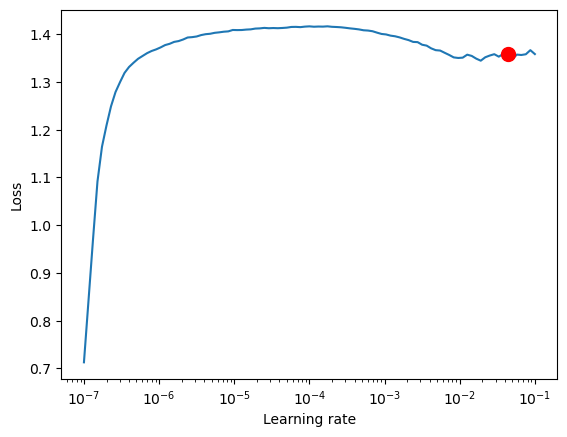

In [14]:
trainer_lr = pl.Trainer.from_argparse_args(args, enable_checkpointing=False, logger=None, auto_lr_find=True)

lr_finder = trainer_lr.tune(model, datamodule=uc4_datamodule, lr_find_kwargs={"min_lr": 1e-7, "max_lr": 1e-1,})

fig=lr_finder['lr_find'].plot(suggest=True)
fig.show()
lr_finder['lr_find'].suggestion()

# Evaluate the Model

In [70]:
!ls represent/represent/weights/

deepcluster_resnet18.pth     uc4_dc_resnet18.pth
dualmoco_resnet50.pth	     uc4_moco_resnet18.pth
moco_resnet18.pth	     uc5_moco_resnet18_12px.pth
simclr_resnet50.pth	     uc5_moco_resnet18_12px_s2_only.pth
uc2_moco_resnet18.pth	     uc5_moco_resnet18_4px.pth
uc2_supervised_resnet18.pth  uc5_moco_resnet18_4px_s2_only.pth


In [19]:
from glob import glob
import os

import wandb
run = wandb.init()
artifact = run.use_artifact('hughes-lloyd/RepreSent_UC4/model-3uc5roi3:v0', type='model')
artifact_dir = artifact.download()

checkpoint = os.path.join(artifact_dir, "model.ckpt")


args.classification_head = torch.nn.Sequential(
    torch.nn.Conv2d(512, config['num_classes'], kernel_size=1),
)

model = UC4ResNet(**args.__dict__)
model.load_state_dict(torch.load(checkpoint)['state_dict'], strict=True)

model = model.to('cuda')
model = model.eval()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hughes-lloyd. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact model-3uc5roi3:v0, 128.40MB. 1 files... Done. 0:0:0.0


In [9]:
from tqdm.notebook import tqdm
from represent.datamodules.uc4_cloud_detection import UC4CloudDetectionDataModule, UC4CloudDetectionDataset
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryJaccardIndex

args.batch_size = 8
args.patch_size = 384
datamodule = UC4CloudDetectionDataModule.from_argparse_args(args,)

datamodule.setup(stage="test")

preds = []
targets = []

metrics = MetricCollection([
    BinaryAccuracy(),
    BinaryPrecision(),
    BinaryRecall(),
    BinaryF1Score(),
    BinaryJaccardIndex(),
]).to("cuda")

c = 0
with torch.no_grad():
    for batch in tqdm(datamodule.test_dataloader()):
        x, y_true = batch
        x, y_true = x.to('cuda'), y_true.to('cuda')
        y_pred = model(x)
        p_pred = torch.sigmoid(y_pred)
        metrics(p_pred, y_true)
        
#         if y_true.sum() > 2000:
#             break

  0%|          | 0/1142 [00:00<?, ?it/s]

In [11]:
metrics.compute()

{'BinaryAccuracy': tensor(0.9781, device='cuda:0'),
 'BinaryPrecision': tensor(0.8822, device='cuda:0'),
 'BinaryRecall': tensor(0.8564, device='cuda:0'),
 'BinaryF1Score': tensor(0.8691, device='cuda:0'),
 'BinaryJaccardIndex': tensor(0.7685, device='cuda:0')}

In [13]:
def plot_result(binary_labels, binary_predictions):
    TP = np.logical_and(binary_labels == 1, binary_predictions == 1)
    TN = np.logical_and(binary_labels == 0, binary_predictions == 0)
    FP = np.logical_and(binary_labels == 0, binary_predictions == 1)
    FN = np.logical_and(binary_labels == 1, binary_predictions == 0)

    # Create an empty RGB image
    h, w = binary_labels.shape
    error_image = np.zeros((h, w, 3), dtype=np.uint8)

    # Set the color for each type of error and correct classification
    # Red: Commission errors (FP)
    # Green: Omission errors (FN)
    # Blue: No errors (TP + TN)
    error_image[FP] = [255, 0, 0]  # Red for commission errors
    error_image[FN] = [0, 255, 0]  # Green for omission errors
    error_image[TP] = [255, 255, 255]  # White for cloudy pixels
    error_image[TN] = [134, 216, 247] # Blue for background pixels 

    # Plot the result
    plt.imshow(error_image)
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.show()

In [57]:
args_test = args
args_test.patch_size = 383

In [58]:
datamodule = UC4CloudDetectionDataModule.from_argparse_args(args_test,)
datamodule.setup("test")
dset = datamodule.test_dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([13, 383, 383])

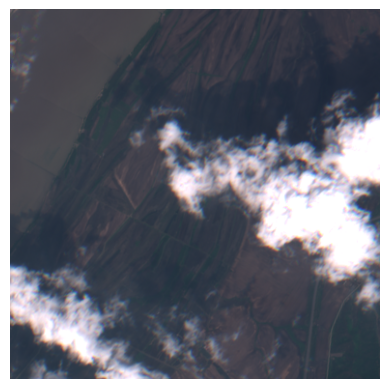

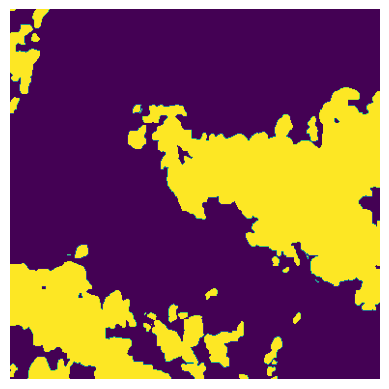

In [59]:
img2, lbl2 = dset[2133]
# img2 = torch.from_numpy(img[:, j:j+128, j:j+128])

plt.figure()
plt.imshow(img2.numpy().transpose(1,2,0)[:,:,(3,2,1)]*2)
plt.axis("off")
plt.figure()
plt.imshow(lbl2.numpy().transpose(1,2,0))
plt.axis("off")

img2.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


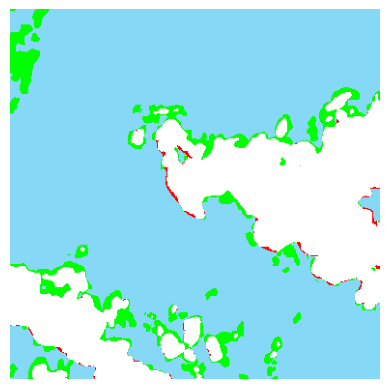

In [60]:
def infer_patch(model, img_patch_t):
    with torch.no_grad():
        img_t = torch.from_numpy(img_patch_t.numpy()[np.newaxis,]).to("cuda")
        o = model(img_t).to('cpu')
    return torch.sigmoid(o)
    
plt.figure()
plt.imshow(img2.numpy().transpose(1,2,0)[:,:,(3,2,1)]*2)
plt.imshow(infer_patch(model, img2)[0,0,].numpy()>0.5, alpha=0.5)
plt.axis("off")

pred = infer_patch(model, img2)[0,0,].numpy()>0.5
gt = lbl2.numpy()[0,]

plot_result(gt, pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: operands could not be broadcast together with shapes (383,383) (384,384) 

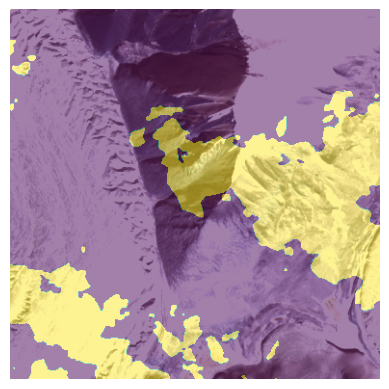

In [61]:
baseline = "/data/lloyd/RepreSent/UC4/CDFM3SF_Masks/S2A_MSIL1C_20190602T021611_N0207_R003_T52TES_20190602T042019.tif"
rast = rasterio.open(baseline)

w_steps = (rast.shape[0]-384)//384 + 1
h_steps = (rast.shape[1]-384)//384 + 1

i = 0
bmask = None
for h in range(h_steps):
    for w in range(w_steps):
        r = h*384
        c = w*384
        i += 1
        
        if i == 569:
            bmask = rast.read(1)[r:r+384, c:c+384]
            break
            
i = 0
pp = None
for h in range(h_steps):
    for w in range(w_steps):
        r = h*384
        c = w*384
        i += 1
        
        if i == 569:
            pp = img[:, r:r+384, c:c+384]
            break
            
plt.figure()
plt.imshow(pp.transpose(1,2,0)[:,:,(3,2,1)]*2)
plt.imshow(bmask, alpha=0.5)
plt.axis("off")

plot_result(gt, bmask//255)


## Full Scale Test

In [34]:
from scipy.ndimage import zoom

# WHUS2_CD_REMAP = (10, 0, 1, 2, 4, 5, 6, 3, 7, 11, 12, 8, 9) #Natural
# WHUS2_CD_REMAP = (10, 2, 1, 0, 4, 5, 6, 3, 11, 8, 12, 9, 7)
WHUS2_CD_REMAP = (10, 0, 1, 2, 4, 5, 6, 3, 9, 11, 12, 7, 8)
# WHUS2_CD_REMAP = (10, 2, 1, 0, 4, 5, 6, 3, 11, 12, 8, 9, 7) #8A last

SCENE_NAME = "S2A_MSIL1C_20210126T052111_N0209_R062_T44SNE_20210126T063836"

imgs = []
band_names = []
annotation = None
sota = None

with rasterio.open(f"/data/lloyd/RepreSent/UC4/CDFM3SF_Masks/{SCENE_NAME}.tif") as src:
    sota = src.read(1).astype(np.float32)//255
    
with rasterio.open(f"/data/lloyd/RepreSent/UC4/WHUS2-CD+/unziped/ReferenceMask/{SCENE_NAME}_Mask.tif") as src:
    annotation = src.read(1).astype(np.float32)//255
    
with rasterio.open(f'/data/lloyd/RepreSent/UC4/WHUS2-CD+/{SCENE_NAME}.zip') as s2a:
    subdatasets = s2a.subdatasets
    
    r10m = rasterio.open(subdatasets[0])
    r20m = rasterio.open(subdatasets[1])
    r60m = rasterio.open(subdatasets[2])
    
    imgs.append(r10m.read().astype(np.float32))
    imgs.append(zoom(r20m.read().astype(np.float32), (1, 2, 2), order=0, mode="nearest", grid_mode=True))
    imgs.append(zoom(r60m.read().astype(np.float32), (1, 6, 6), order=0, mode="nearest", grid_mode=True))
    
    band_names.append([b.split(',')[0] for b in r10m.descriptions])
    band_names.append([b.split(',')[0] for b in r20m.descriptions])
    band_names.append([b.split(',')[0] for b in r60m.descriptions])

img = np.concatenate(imgs, axis=0)[
            WHUS2_CD_REMAP,
        ]
img = img.astype(np.float32) / 10000

In [33]:
# WHUS2_CD_REMAP = (10, 2, 1, 0, 4, 5, 6, 3, 11, 12, 8, 9, 7)

np.concatenate(band_names, axis=0)[
            WHUS2_CD_REMAP,
        ]

[['B4', 'B3', 'B2', 'B8'],
 ['B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
 ['B1', 'B9', 'B10']]

In [29]:
patch_sz = 256
ch, row, col = img.shape

map_biomass = np.zeros((row, col))

with torch.no_grad():
    for r in tqdm(range(0, row, patch_sz-16)):
        for c in range(0, col, patch_sz-16):
#             patch = stack.isel(y=slice(r, r+patch_sz), x=slice(c, c+patch_sz)).load().data
            patch = img[:, slice(r, r+patch_sz), slice(c, c+patch_sz)].copy()
            patch = patch[np.newaxis, ]
            
            s2p = torch.from_numpy(patch).to("cuda")
            y_pred = model(s2p).to('cpu')
            
            y_pred = torch.sigmoid(y_pred)[0,].numpy().transpose(1,2,0)

            map_biomass[slice(r, r+patch_sz), slice(c, c+patch_sz)] = y_pred[:,:,0]
            

  0%|          | 0/46 [00:00<?, ?it/s]

In [49]:
map_biomass.shape

(10980, 10980)

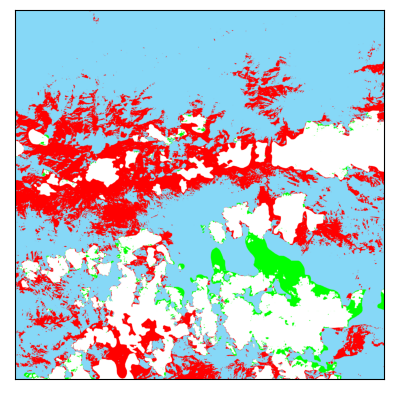

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 4999.5, 4999.5, -0.5)

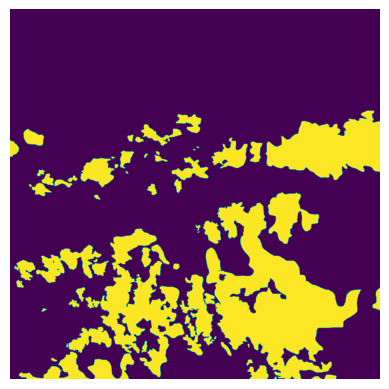

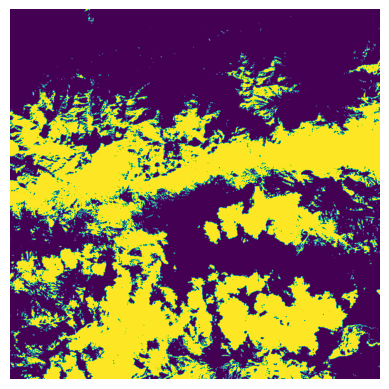

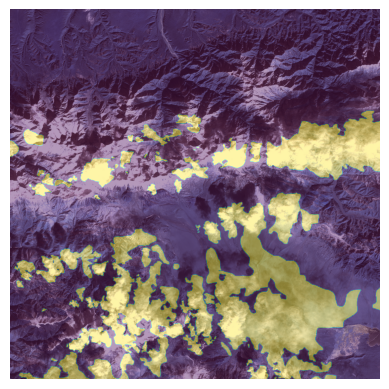

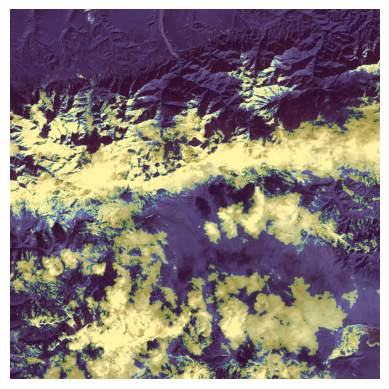

In [55]:
t = 0.5

s1 = slice(0, 5000)
s2 = slice(0, 5000)
plot_result(annotation[s1, s2], map_biomass[s1, s2]>t)


plt.figure()
plt.imshow(annotation[s1, s2])
plt.axis("off")
plt.figure()
plt.imshow(map_biomass[s1, s2]>t)
plt.axis("off")
plt.figure()
plt.imshow(img.transpose(1,2,0)[s1, s2,(3,2,1)]*2)
plt.imshow(annotation[s1, s2], alpha=0.4)
plt.axis("off")

plt.figure()
plt.imshow(img.transpose(1,2,0)[s1, s2,(3,2,1)]*2)
plt.imshow(map_biomass[s1, s2]>t, alpha=0.4)
plt.axis("off")

